In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
pip install librosa

In [0]:
import librosa

In [0]:
from librosa import display

In [0]:
data, sampling_rate =librosa.load('/content/drive/My Drive/03-01-01-01-01-01-01.wav')

In [0]:
%pylab inline

In [0]:
import os

In [0]:
import pandas as pd

In [0]:
import glob

In [0]:
plt.figure(figsize=(12, 4))

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

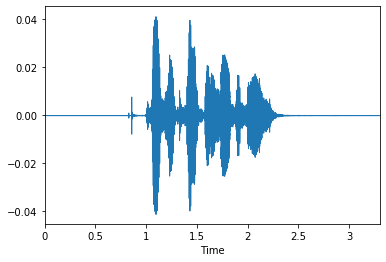

In [0]:
librosa.display.waveplot(data, sr=sampling_rate)

In [0]:
import time
path = '/content/drive/My Drive/Ravdess'

In [0]:
lst = []

In [0]:
start_time = time.time()

In [0]:
for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 1698.0222883224487 seconds ---


In [0]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [0]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2900, 40), (2900,))

In [0]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/My Drive/Ravdess'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [0]:
# Loading saved models

X = joblib.load('/content/drive/My Drive/Ravdess/X.joblib')
y = joblib.load('/content/drive/My Drive/Ravdess/y.joblib')


#Decision Tree classifier
#To make a first attempt in accomplishing this classification task I chose a decision tree:


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
dtree = DecisionTreeClassifier()

In [0]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
predictions = dtree.predict(X_test)

Let's go with our classification report.
Before we start, a quick reminder of the classes we are trying to predict:
emotions = { "neutral": "0", "calm": "1", "happy": "2", "sad": "3", "angry": "4", "fearful": "5", "disgust": "6", "surprised": "7" }

In [0]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83        73
           1       0.89      0.89      0.89       122
           2       0.69      0.67      0.68       121
           3       0.74      0.78      0.76       130
           4       0.82      0.85      0.84       137
           5       0.75      0.85      0.80       120
           6       0.88      0.73      0.79       131
           7       0.71      0.80      0.76       123

    accuracy                           0.79       957
   macro avg       0.80      0.79      0.79       957
weighted avg       0.80      0.79      0.79       957



# Random Forest¶
In this second approach, I switched to a random forest classifier and I made a gridsearch to make some hyperparameters tuning.
The gridsearch is not shown in the code below otherwise the notebook will require too much time to run.

In [0]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [0]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [0]:
predictions = rforest.predict(X_test)

In [0]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.42      0.60        73
           1       0.66      0.97      0.78       122
           2       0.77      0.69      0.72       121
           3       0.77      0.72      0.74       130
           4       0.92      0.80      0.85       137
           5       0.75      0.79      0.77       120
           6       0.77      0.79      0.78       131
           7       0.73      0.82      0.77       123

    accuracy                           0.77       957
   macro avg       0.80      0.75      0.75       957
weighted avg       0.79      0.77      0.76       957



# Neural network
Let's build our neural network!
To do so, we need to expand the dimensions of our array, adding a third one using the numpy "expand_dims" feature.

In [0]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [0]:
x_traincnn.shape, x_testcnn.shape

((1943, 40, 1), (957, 40, 1))

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


In [0]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001,decay=1e-6)

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_5 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)           

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Train on 1943 samples, validate on 957 samples
Epoch 1/1000
1943/1943 [==============================] - 1s 536us/step - loss: 0.8960 - acc: 0.6830 - val_loss: 1.0382 - val_acc: 0.6374
Epoch 2/1000
1943/1943 [==============================] - 1s 544us/step - loss: 0.8954 - acc: 0.6953 - val_loss: 1.0386 - val_acc: 0.6520
Epoch 3/1000
1943/1943 [==============================] - 1s 483us/step - loss: 0.8895 - acc: 0.6927 - val_loss: 1.0318 - val_acc: 0.6573
Epoch 4/1000
1943/1943 [==============================] - 1s 490us/step - loss: 0.9031 - acc: 0.6850 - val_loss: 1.0364 - val_acc: 0.6447
Epoch 5/1000
1943/1943 [==============================] - 1s 524us/step - loss: 0.8966 - acc: 0.6840 - val_loss: 1.0321 - val_acc: 0.6447
Epoch 6/1000
1943/1943 [==============================] - 1s 521us/step - loss: 0.8910 - acc: 0.7005 - val_loss: 1.0308 - val_acc: 0.6458
Epoch 7/1000
1943/1943 [==============================] - 1s 520us/step - loss: 0.8756 - acc: 0.7072 - val_loss: 1.0327 - val

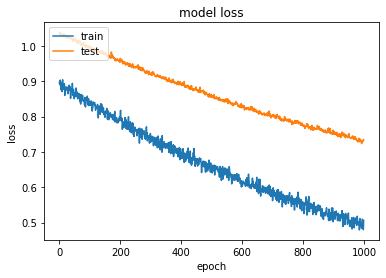

In [0]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

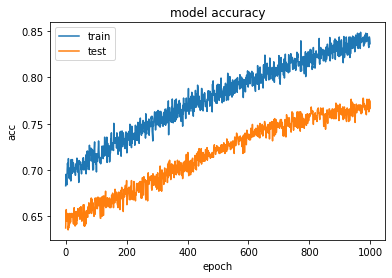

In [0]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
predictions = model.predict_classes(x_testcnn)

In [0]:
predictions

In [0]:
y_test

array([7, 3, 6, 5, 6, 7, 5, 2, 6, 5, 2, 6, 4, 7, 1, 1, 6, 3, 3, 3, 6, 7,
       5, 3, 3, 5, 7, 4, 5, 0, 6, 6, 1, 2, 2, 6, 7, 3, 7, 4, 2, 4, 4, 7,
       5, 7, 5, 7, 6, 0, 4, 5, 6, 1, 4, 1, 4, 5, 1, 1, 6, 7, 1, 3, 7, 7,
       5, 2, 0, 6, 4, 2, 5, 6, 2, 2, 6, 7, 6, 1, 7, 1, 1, 7, 5, 0, 0, 5,
       3, 5, 6, 3, 1, 1, 2, 6, 2, 4, 1, 0, 7, 5, 2, 0, 3, 7, 4, 7, 2, 1,
       5, 7, 3, 7, 7, 2, 3, 4, 1, 3, 4, 1, 4, 7, 2, 0, 5, 4, 4, 2, 3, 1,
       4, 1, 6, 1, 7, 2, 3, 5, 7, 1, 1, 5, 7, 4, 0, 6, 4, 3, 5, 2, 4, 1,
       4, 2, 6, 4, 4, 7, 3, 6, 3, 1, 1, 1, 0, 4, 1, 6, 5, 5, 3, 0, 3, 1,
       4, 5, 2, 1, 2, 1, 1, 0, 6, 5, 2, 2, 0, 5, 7, 2, 0, 5, 1, 4, 3, 5,
       4, 6, 4, 6, 7, 2, 7, 6, 7, 6, 2, 7, 6, 5, 3, 3, 7, 6, 4, 1, 2, 4,
       3, 3, 1, 2, 1, 1, 2, 7, 1, 5, 3, 1, 5, 7, 6, 6, 4, 5, 5, 4, 2, 2,
       1, 7, 1, 1, 7, 6, 4, 2, 5, 2, 4, 7, 3, 3, 5, 0, 2, 4, 5, 6, 2, 3,
       0, 6, 5, 0, 2, 7, 3, 1, 1, 6, 2, 3, 5, 2, 0, 6, 4, 3, 6, 7, 2, 3,
       6, 3, 5, 2, 4, 6, 7, 6, 4, 7, 3, 5, 2, 6, 6,

In [0]:
new_Ytest = y_test.astype(int)

In [0]:
new_Ytest

array([7, 3, 6, 5, 6, 7, 5, 2, 6, 5, 2, 6, 4, 7, 1, 1, 6, 3, 3, 3, 6, 7,
       5, 3, 3, 5, 7, 4, 5, 0, 6, 6, 1, 2, 2, 6, 7, 3, 7, 4, 2, 4, 4, 7,
       5, 7, 5, 7, 6, 0, 4, 5, 6, 1, 4, 1, 4, 5, 1, 1, 6, 7, 1, 3, 7, 7,
       5, 2, 0, 6, 4, 2, 5, 6, 2, 2, 6, 7, 6, 1, 7, 1, 1, 7, 5, 0, 0, 5,
       3, 5, 6, 3, 1, 1, 2, 6, 2, 4, 1, 0, 7, 5, 2, 0, 3, 7, 4, 7, 2, 1,
       5, 7, 3, 7, 7, 2, 3, 4, 1, 3, 4, 1, 4, 7, 2, 0, 5, 4, 4, 2, 3, 1,
       4, 1, 6, 1, 7, 2, 3, 5, 7, 1, 1, 5, 7, 4, 0, 6, 4, 3, 5, 2, 4, 1,
       4, 2, 6, 4, 4, 7, 3, 6, 3, 1, 1, 1, 0, 4, 1, 6, 5, 5, 3, 0, 3, 1,
       4, 5, 2, 1, 2, 1, 1, 0, 6, 5, 2, 2, 0, 5, 7, 2, 0, 5, 1, 4, 3, 5,
       4, 6, 4, 6, 7, 2, 7, 6, 7, 6, 2, 7, 6, 5, 3, 3, 7, 6, 4, 1, 2, 4,
       3, 3, 1, 2, 1, 1, 2, 7, 1, 5, 3, 1, 5, 7, 6, 6, 4, 5, 5, 4, 2, 2,
       1, 7, 1, 1, 7, 6, 4, 2, 5, 2, 4, 7, 3, 3, 5, 0, 2, 4, 5, 6, 2, 3,
       0, 6, 5, 0, 2, 7, 3, 1, 1, 6, 2, 3, 5, 2, 0, 6, 4, 3, 6, 7, 2, 3,
       6, 3, 5, 2, 4, 6, 7, 6, 4, 7, 3, 5, 2, 6, 6,

In [0]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.51      0.62        73
           1       0.79      0.95      0.86       122
           2       0.77      0.64      0.70       121
           3       0.68      0.69      0.68       130
           4       0.81      0.78      0.80       137
           5       0.80      0.84      0.82       120
           6       0.76      0.85      0.81       131
           7       0.81      0.81      0.81       123

    accuracy                           0.77       957
   macro avg       0.78      0.76      0.76       957
weighted avg       0.78      0.77      0.77       957



In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

[[ 37   9   4  17   0   4   1   1]
 [  1 116   1   1   0   0   3   0]
 [  0   5  78   9  10   7   4   8]
 [  3  13   3  90   4  10   2   5]
 [  0   1   6   2 107   3  16   2]
 [  0   3   3   5   4 101   4   0]
 [  1   0   0   6   2   2 112   8]
 [  4   0   6   3   5   0   5 100]]


# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

# Save the model

In [0]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/content/drive/My Drive/Ravdess'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Ravdess/Emotion_Voice_Detection_Model.h5 


# Reloading the model to test it

In [0]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Ravdess/Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_5 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)           

# Checking the accuracy of the loaded model



In [0]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

957/957 [==============================] - 0s 194us/step
Restored model, accuracy: 77.43%
